<a href="https://colab.research.google.com/github/AshkanSamavatian/Thesis/blob/main/Thesis__Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Installing and Importing required libraries**

In [ ]:
#Installing required libraries for the project
!pip install -q transformers datasets evaluate torch
!pip install -q datasets
!pip install -q bert-score
!pip install -q git+https://github.com/google-research/bleurt.git
!pip install -q nlpaug

#Importing fundamental libraries for the project
import os
import random
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split
from datasets import Dataset
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, DataCollatorWithPadding, Trainer, EarlyStoppingCallback, AutoModelForMaskedLM, pipeline, T5ForConditionalGeneration, T5Tokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer
from evaluate import load
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from scipy.stats import ttest_ind, wilcoxon
import nlpaug.augmenter.word as naw
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
os.environ["WANDB_DISABLED"]="true"
torch.autograd.set_detect_anomaly(True)
%env CUDA_LAUNCH_BLOCKING=1

#Reproducibility Function
def set_seed(seed=101):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True  #Ensuring deterministic behavior
    torch.backends.cudnn.benchmark=False  #Disabling automatic optimizations

#Setting seed globally
set_seed(101)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.8 MB/s eta 0:00:00
env: CUDA_LAUNCH_BLOCKING=1


### **Importing, Reviewing, and Preparing FLUTE Dataset for the Project**

In [ ]:
#Importing the FLUTE dataset
uploaded=files.upload()

#Reading and storing the FLUTE dataset
flute_df=pd.read_csv("train.csv")

#Overviewing the FLUTE dataset
flute_df.info()

Saving train.csv to train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7534 entries, 0 to 7533
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7534 non-null   int64 
 1   premise      7534 non-null   object
 2   hypothesis   7534 non-null   object
 3   label        7534 non-null   object
 4   explanation  7530 non-null   object
 5   split        7534 non-null   object
 6   type         7534 non-null   object
 7   idiom        1768 non-null   object
dtypes: int64(1), object(7)
memory usage: 471.0+ KB


In [ ]:
#Monitoring the FLUTE dataset
flute_df.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
0,1,I left my adult son home for a few days and ju...,I was gone for only a few days and my consider...,Contradiction,Most people would not consider leaving dirty d...,train,Sarcasm,NaN
1,2,I just caught a guy picking up used chewing gu...,it was such a pleasant sight to see a guy pick...,Contradiction,Picking up used chewing gum is really unhygien...,train,Sarcasm,NaN
2,3,You could feel their sudden appearance in the ...,Their sudden appearance in the farmhouse was l...,Entailment,A gust of arctic wind is an icy blast that is ...,train,Simile,NaN
3,4,"April's had never left, perfectly white and fu...","April's had never left, like a toothpaste comm...",Entailment,A toothpaste commercial is something that is a...,train,Simile,NaN
4,5,I cooked a meal for family and it came out hor...,I feel terrible that the meal I cooked for my ...,Entailment,It is often very embarrassing when someone coo...,train,CreativeParaphrase,NaN


In [ ]:
#Defining a function to analyze and review the columns in the FLUTE dataset
def analyze_columns(dataframe, columns):
    """
    Analyze specified columns of a DataFrame by providing the number of unique values
    and the value counts for each column.
    Args:
        dataframe (pd.DataFrame): The DataFrame to analyze.
        columns (list): List of column names to analyze.
    Returns:
        dict: A dictionary where each key is a column name, and the value is a tuple
              (number_of_unique_values, value_counts_series).
    """
    analysis_results={}
    for column in columns:
        if column in dataframe.columns:
            unique_count=len(set(dataframe[column]))
            value_counts=dataframe[column].value_counts()
            analysis_results[column]=(unique_count, value_counts)
        else:
            print(f"Warning: Column '{column}' not found in the DataFrame.")
    return analysis_results

#Reviewing the "premise", "hypothesis", "label", "explanation", and "type" columns in the FLUTE dataset
results=analyze_columns(flute_df, ["premise", "hypothesis", "label", "explanation", "type"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-" * 50)

Column: premise
Number of unique values: 5492
Value counts:
premise
I am worried I will not be able to go to my fathers birthday party.                                            6
I've been hearing some strange noises around the house at night.                                               6
I was really stressed out and grad school and had no choice but to drop out to keep my sanity.                 6
I missed my flight that I paid heavily for, I was so annoyed                                                   6
I found drugs in my son's room and I am beyond infuriated!                                                     3
                                                                                                              ..
The bullet retreated her chest.                                                                                1
I knew I wasn't strong enough to put up a wall against it, but I would not admit defeat or plead for mercy.    1
The library grew back in an 

In [ ]:
#Defining the validation size
validation_size=0.2

#Spliting the FLUTE dataset into training and validation sets
flute_train, flute_val=train_test_split(flute_df, test_size=validation_size, random_state=101)

#Checking the sizes of the splits
print(f"FLUTE Training set size: {len(flute_train)}")
print(f"FLUTE Validation set size: {len(flute_val)}")

FLUTE Training set size: 6027
FLUTE Validation set size: 1507


In [ ]:
#Overviewing the FLUTE Training set
flute_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6027 entries, 2279 to 4959
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           6027 non-null   int64 
 1   premise      6027 non-null   object
 2   hypothesis   6027 non-null   object
 3   label        6027 non-null   object
 4   explanation  6023 non-null   object
 5   split        6027 non-null   object
 6   type         6027 non-null   object
 7   idiom        1416 non-null   object
dtypes: int64(1), object(7)
memory usage: 423.8+ KB


In [ ]:
#Monitoring the FLUTE Training set
flute_train.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
2279,2280,Some unintelligent and unsuccessful young pers...,Some bright young thing had gotten ahold of a ...,Contradiction,A bright young thing is a young person who is ...,train,Idiom,bright young thing
1308,1309,"Once now remember, this is a vacation, not car...","Once now remember, this is a vacation, not car...",Contradiction,To run amok means to go awry or to act out of ...,train,Idiom,run amok
6921,6922,Now he feels agitated,Now he feels like a high mountain lake without...,Contradiction,A mountain lake without any wind stirring it i...,train,Simile,NaN
4155,4156,I had a box chocolate when my doctor advised a...,I broke my diet by eating a box of chocolates ...,Contradiction,A diet is often broken when someone eats somet...,train,Sarcasm,NaN
6323,6324,"It wasn't glib or run of the mill ,it wasn't i...","It wasn't glib or run of the mill ,it didn't g...",Entailment,The idiom in one ear and out the other is used...,train,Idiom,in one ear and out the other


In [ ]:
#Reviewing the "premise", "hypothesis", "label", "explanation", and "type" columns in the FLUTE training set
results=analyze_columns(flute_train, ["premise", "hypothesis", "label", "explanation", "type"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-" * 50)

Column: premise
Number of unique values: 4628
Value counts:
premise
I've been hearing some strange noises around the house at night.                                                                5
I am worried I will not be able to go to my fathers birthday party.                                                             5
I was really stressed out and grad school and had no choice but to drop out to keep my sanity.                                  4
I don't like it when mosquitoes attack me while I'm having a good time at the beach                                             3
I had to give my pet up for adoption because my new apartment wouldn't take them.                                               3
                                                                                                                               ..
My words sounded weak.                                                                                                          1
She had fabricated the

In [ ]:
#Overviewing the FLUTE Validation set
flute_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1507 entries, 4822 to 3176
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1507 non-null   int64 
 1   premise      1507 non-null   object
 2   hypothesis   1507 non-null   object
 3   label        1507 non-null   object
 4   explanation  1507 non-null   object
 5   split        1507 non-null   object
 6   type         1507 non-null   object
 7   idiom        352 non-null    object
dtypes: int64(1), object(7)
memory usage: 106.0+ KB


In [ ]:
#Monitoring the FLUTE Validation set
flute_val.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
4822,4823,My boss suddenly just took that project I was ...,I'm so glad my boss just took that project I h...,Contradiction,The boss taking a project away from an employ...,train,Sarcasm,NaN
6862,6863,Clementine was pinned securely,Clementine was pinned like a butterfly in a gl...,Entailment,A butterfly in a glass case is pinned down and...,train,Simile,NaN
1571,1572,"Once we commit to a significant response, it n...","Once we commit to a significant response, it n...",Entailment,"To bear fruit means to yield results, so in th...",train,Idiom,bear fruit
3293,3294,"He was about sixty, short and fat .","He was about sixty, like a big soccer ball .",Entailment,"A soccer ball is short and fat, so the simile ...",train,Simile,NaN
4713,4714,"The overhead light buzzed soothingly, at the e...",The overhead light buzzed at the edge of heari...,Contradiction,"Flies buzz irritatingly, not soothingly",train,Simile,NaN


In [ ]:
#Reviewing the "premise", "hypothesis", "label", "explanation", and "type" columns in the FLUTE validation set
results=analyze_columns(flute_val, ["premise", "hypothesis", "label", "explanation", "type"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-" * 50)

Column: premise
Number of unique values: 1385
Value counts:
premise
My dog keeps going into my garbage and throwing the contents onto the floor.                                       3
I was on an airplane last week, and someone's baby would not stop crying.                                          3
During an important school event, my shorts fell down when I was running and my whole team was counting on me      3
I bit into an apple and found a worm and it was so gross.                                                          3
I missed my flight that I paid heavily for, I was so annoyed                                                       3
                                                                                                                  ..
Even though you decline, the man is still apathetic.                                                               1
You need to actively try to change or control the situation and not just go with it.                             

In [ ]:
#Importing the FLUTE test set
uploaded=files.upload()

#Reading and storing the FLUTE test set
test_df=pd.read_csv("test2.csv")

#Overviewing the FLUTE test set
test_df.info()

Saving test2.csv to test2.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1498 non-null   int64 
 1   premise      1498 non-null   object
 2   hypothesis   1498 non-null   object
 3   label        1498 non-null   object
 4   explanation  1498 non-null   object
 5   split        1498 non-null   object
 6   type         1498 non-null   object
 7   idiom        250 non-null    object
dtypes: int64(1), object(7)
memory usage: 93.8+ KB


In [ ]:
#Monitoring the FLUTE test set
test_df.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
0,1,I went to a buffet the other day and they kick...,I felt amazing when the buffet staff threw me ...,Contradiction,Being thrown out of a buffet for eating too mu...,test,Sarcasm,NaN
1,2,"Because I know Ronin's confidantes, and they w...","Because I know Ronin's confidantes, and they w...",Entailment,To tell tales out of school means to share sec...,test,Idiom,tell tales out of school
2,3,"I just broke up with my girlfriend, we were to...",Loving this life of loneliness after breaking ...,Contradiction,Loneliness is not a desirable feeling and is o...,test,Sarcasm,NaN
3,4,The government allowed the value of the ruble ...,The government floated the ruble for a few mon...,Entailment,Floating the ruble means that the government a...,test,Metaphor,NaN
4,5,Another girl was flirting with my boyfriend at...,I really felt cooperative when I saw another g...,Contradiction,Seeing someone else flirt with your boyfriend ...,test,Sarcasm,NaN


In [ ]:
#Reviewing the "premise", "hypothesis", "label", "explanation", and "type" columns in the FLUTE test set
results=analyze_columns(test_df, ["premise", "hypothesis", "label", "explanation", "type"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-" * 50)

Column: premise
Number of unique values: 1186
Value counts:
premise
The kitchen was a total mess with old pile up of dishes and dried up food on the stove.                    3
When my boyfriend left me for another woman on Valentine's Day that really sucked being left all alone.    3
My landlord takes rent but he doesn't want to make any reparations.                                        3
My dishwasher leaked and we had to have our whole kitchen and living room redone due to the damages.       3
I can't get pregnant but all my friends are having kids.                                                   3
                                                                                                          ..
Josh is part of a techno band.                                                                             1
I've been getting really bad headaches recently                                                            1
Phillip wasn't brave enough to deal with something deadly.  

### **Model Training and Evaluation Process for ROBERTA and BERT Models**

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Processing Model: roberta-base



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing data for roberta-base...


Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/1507 [00:00<?, ? examples/s]

Map:   0%|          | 0/1507 [00:00<?, ? examples/s]

Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


dict_keys(['input_ids', 'attention_mask'])
Setting training arguments for roberta-base...
Initializing Trainer for roberta-base...
Training roberta-base...


Epoch,Training Loss,Validation Loss
1,No log,0.132586
2,0.287200,0.113678
3,0.068900,0.098025
4,0.019700,0.104894
5,0.019700,0.087026


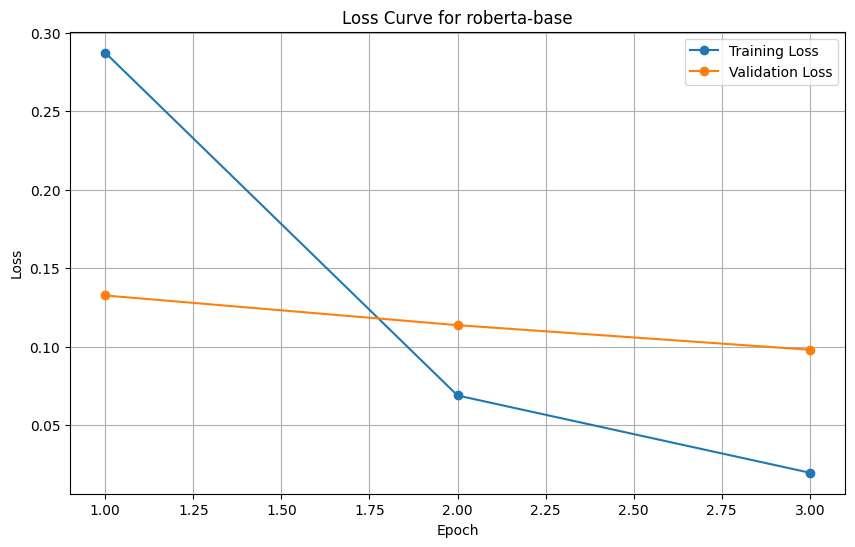

Evaluating roberta-base on Validation Set...


{'eval_loss': 0.08702555298805237, 'eval_runtime': 4.3028, 'eval_samples_per_second': 350.239, 'eval_steps_per_second': 22.079, 'epoch': 5.0}
Evaluating roberta-base on Test Set...
{'eval_loss': 1.8136310577392578, 'eval_runtime': 4.2606, 'eval_samples_per_second': 351.59, 'eval_steps_per_second': 22.062, 'epoch': 5.0}
Generating predictions for roberta-base...
Class Accuracies for roberta-base: {0: 0.6213333333333333, 1: 0.944, 2: 0.996, 3: 0.9354838709677419}


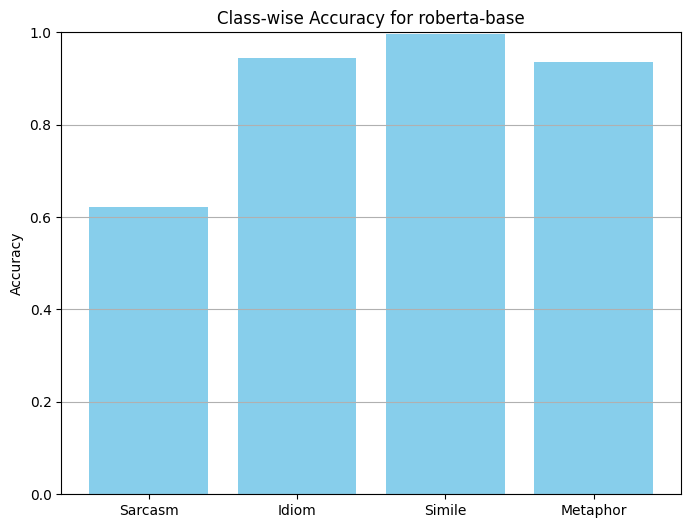

Accuracy for roberta-base: 0.79
Classification Report for roberta-base:
                    precision    recall  f1-score   support

           Sarcasm       1.00      0.62      0.77       750
             Idiom       0.95      0.94      0.95       250
            Simile       0.97      1.00      0.98       250
          Metaphor       0.96      0.94      0.95       248
CreativeParaphrase       0.00      0.00      0.00         0

          accuracy                           0.79      1498
         macro avg       0.77      0.70      0.73      1498
      weighted avg       0.98      0.79      0.86      1498



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


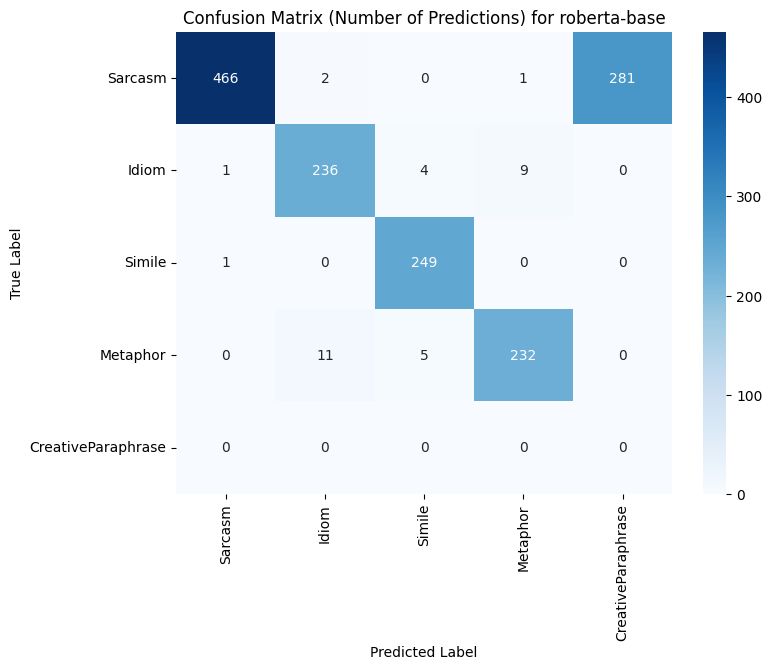

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


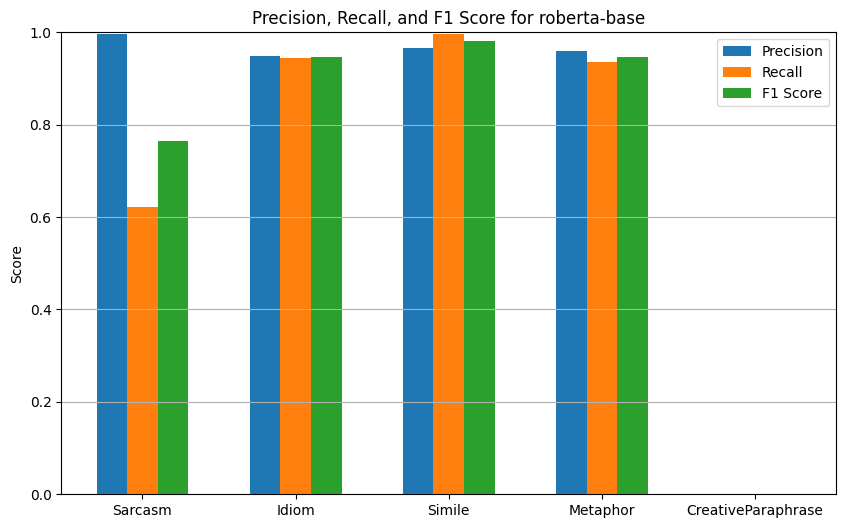

BLEU Score for roberta-base: 0.7580
Average BLEURT Score for roberta-base: 0.4254


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore F1 for roberta-base: 0.9571


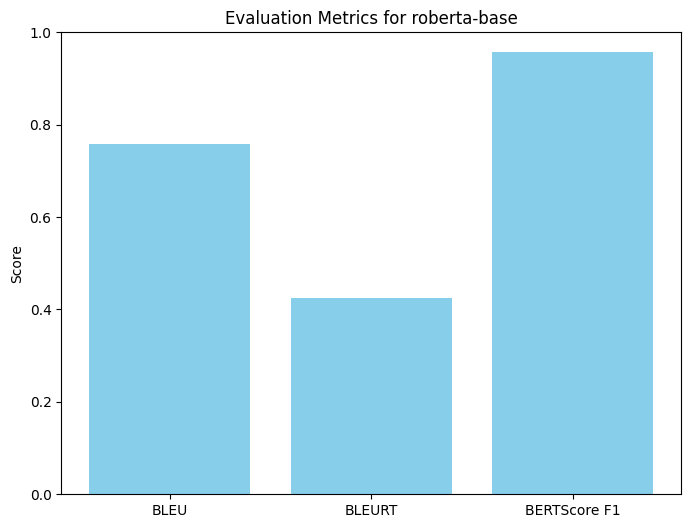

Total misclassified examples for roberta-base: 315/1498
Misclassified examples for roberta-base: [(19, 0, 4), (23, 0, 4), (25, 0, 4), (41, 0, 4), (47, 0, 4)]
Sample Misclassified Examples for roberta-base:
Example 19:
  - True Label: Sarcasm
  - Predicted Label: CreativeParaphrase
  - Premise: Mismatched prediction
  - Hypothesis: I was really excited to inherit my mom's old car but when I got it, I realized the trunk leaked
--------------------------------------------------
Example 23:
  - True Label: Sarcasm
  - Predicted Label: CreativeParaphrase
  - Premise: Mismatched prediction
  - Hypothesis: The fact that the price for the part I need for my computer went up 10% right before I decided to buy it made me furious
--------------------------------------------------
Example 25:
  - True Label: Sarcasm
  - Predicted Label: CreativeParaphrase
  - Premise: Mismatched prediction
  - Hypothesis: I get really pissed off when my husband leaves his dirty clothes on the floor
----------------

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing data for bert-base-uncased...


Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/1507 [00:00<?, ? examples/s]

Map:   0%|          | 0/1507 [00:00<?, ? examples/s]

Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Setting training arguments for bert-base-uncased...
Initializing Trainer for bert-base-uncased...
Training bert-base-uncased...


Epoch,Training Loss,Validation Loss
1,No log,0.120450
2,0.269200,0.102601
3,0.039100,0.098403
4,0.006600,0.088269
5,0.006600,0.086937


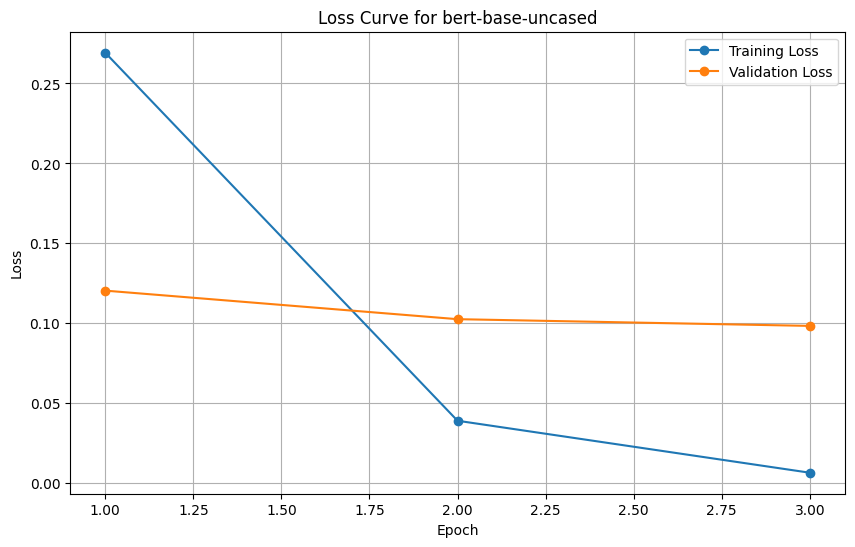

Evaluating bert-base-uncased on Validation Set...


{'eval_loss': 0.0869373008608818, 'eval_runtime': 4.9539, 'eval_samples_per_second': 304.205, 'eval_steps_per_second': 19.177, 'epoch': 5.0}
Evaluating bert-base-uncased on Test Set...
{'eval_loss': 1.820013403892517, 'eval_runtime': 5.1253, 'eval_samples_per_second': 292.275, 'eval_steps_per_second': 18.34, 'epoch': 5.0}
Generating predictions for bert-base-uncased...
Class Accuracies for bert-base-uncased: {0: 0.6146666666666667, 1: 0.92, 2: 0.992, 3: 0.9395161290322581}


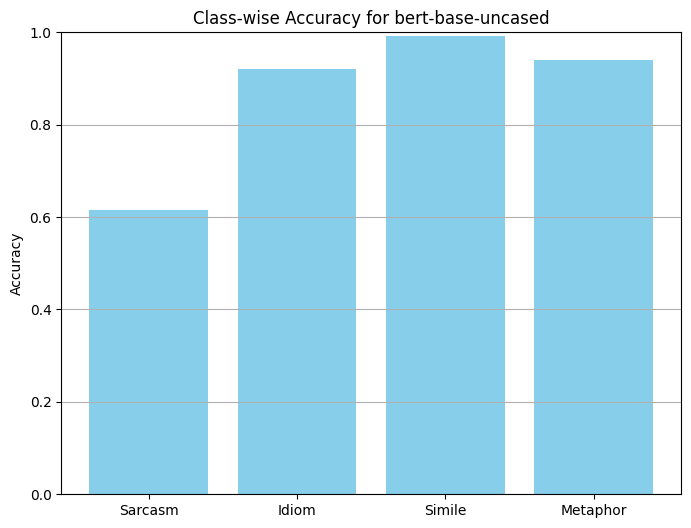

Accuracy for bert-base-uncased: 0.78
Classification Report for bert-base-uncased:
                    precision    recall  f1-score   support

           Sarcasm       0.99      0.61      0.76       750
             Idiom       0.95      0.92      0.93       250
            Simile       0.98      0.99      0.99       250
          Metaphor       0.94      0.94      0.94       248
CreativeParaphrase       0.00      0.00      0.00         0

          accuracy                           0.78      1498
         macro avg       0.77      0.69      0.72      1498
      weighted avg       0.97      0.78      0.86      1498



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


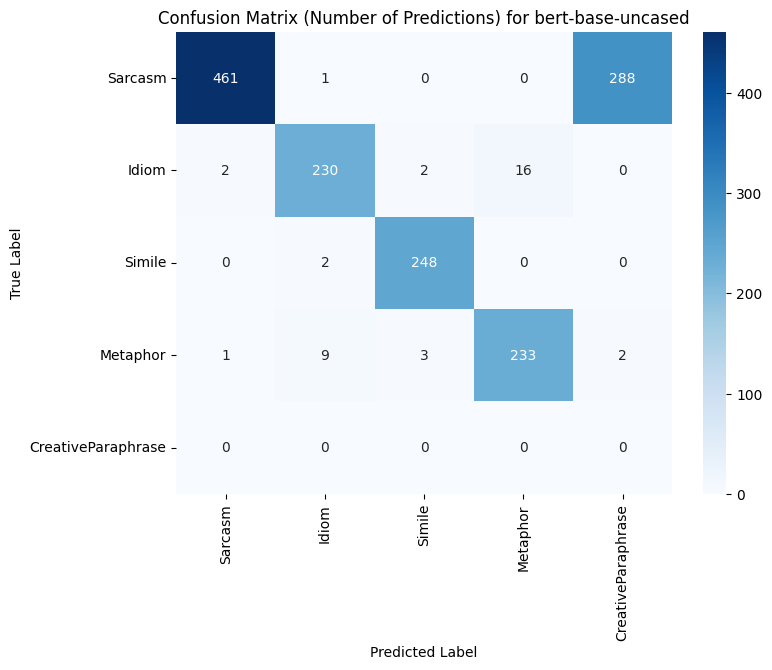

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


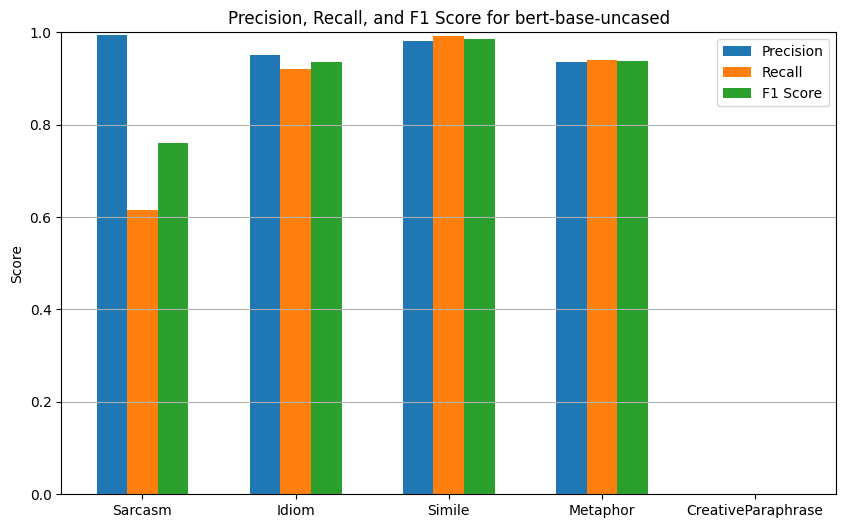

BLEU Score for bert-base-uncased: 0.7525
Average BLEURT Score for bert-base-uncased: 0.4091
Average BERTScore F1 for bert-base-uncased: 0.9557


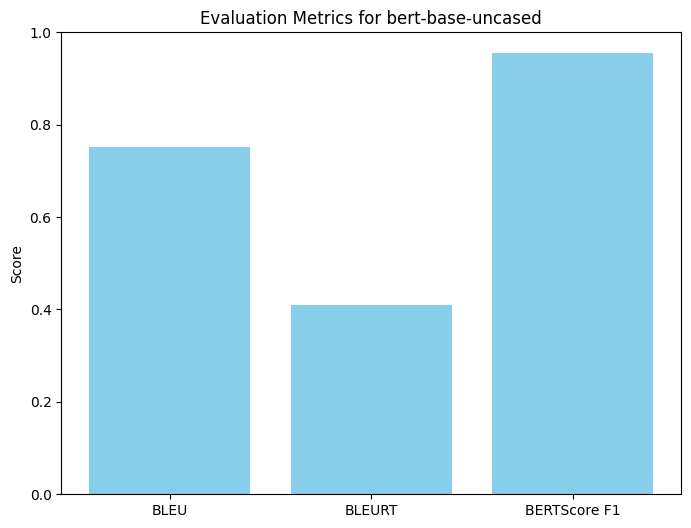

Total misclassified examples for bert-base-uncased: 326/1498
Misclassified examples for bert-base-uncased: [(17, 0, 4), (19, 0, 4), (23, 0, 4), (25, 0, 4), (41, 0, 4)]
Sample Misclassified Examples for bert-base-uncased:
Example 17:
  - True Label: Sarcasm
  - Predicted Label: CreativeParaphrase
  - Premise: Mismatched prediction
  - Hypothesis: It's amazing that my boss takes advantage of me being a hard worker and never appreciates my efforts
--------------------------------------------------
Example 19:
  - True Label: Sarcasm
  - Predicted Label: CreativeParaphrase
  - Premise: Mismatched prediction
  - Hypothesis: I was really excited to inherit my mom's old car but when I got it, I realized the trunk leaked
--------------------------------------------------
Example 23:
  - True Label: Sarcasm
  - Predicted Label: CreativeParaphrase
  - Premise: Mismatched prediction
  - Hypothesis: The fact that the price for the part I need for my computer went up 10% right before I decided to b

,Model,Accuracy,BLEU,BLEURT,BERTScore F1
0,roberta-base,0.789720,0.757965,0.425396,0.957065
1,bert-base-uncased,0.782377,0.752468,0.409050,0.955657


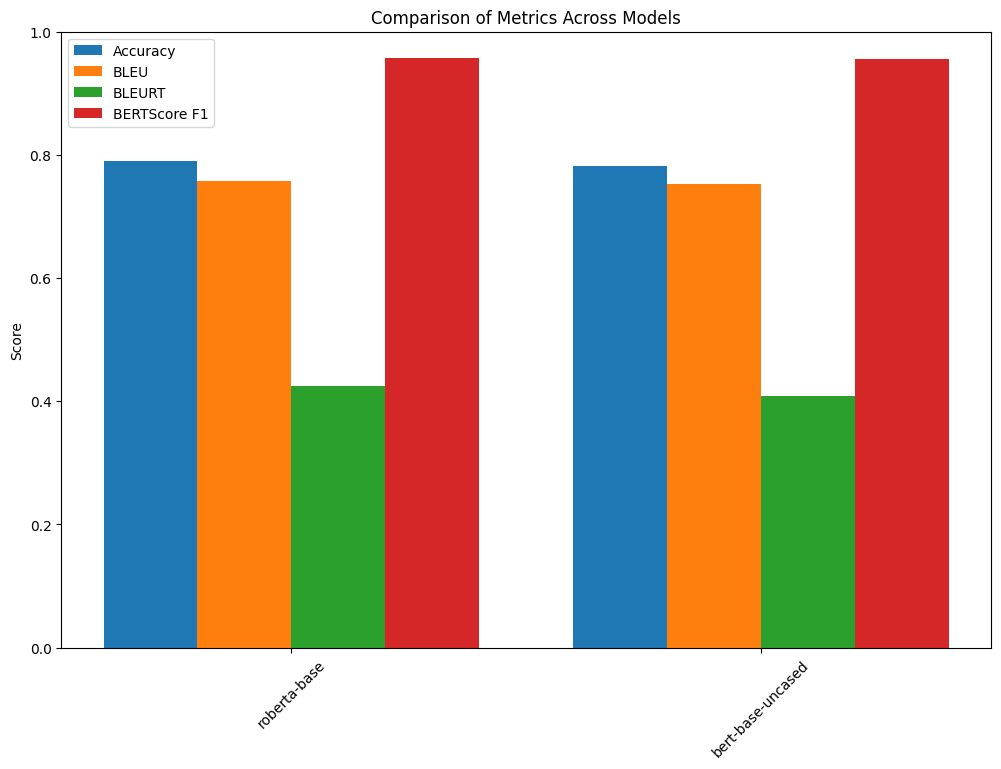

In [ ]:
#Converting Pandas DataFrames to Hugging Face Datasets
hf_flute_train=Dataset.from_pandas(flute_train)
hf_flute_val=Dataset.from_pandas(flute_val)
hf_test_dataset=Dataset.from_pandas(test_df)

#List of the models
model_names=[
    "roberta-base",
    "bert-base-uncased"
]

#Type mapping
type_mapping={"Sarcasm": 0, "Idiom": 1, "Simile": 2, "Metaphor": 3, "CreativeParaphrase": 4}

#Defining a tokenization function
def tokenize_function(dataframe):
    return tokenizer(
        dataframe["premise"],
        dataframe["hypothesis"],
        padding="max_length",
        truncation=True,
        )

#Importing evaluation metrics
bleu_metric=load("bleu")
bleurt_metric=load("bleurt")
bertscore_metric=load("bertscore")

#Initializing a list to store performance metrics for all models
model_performance=[]

#Loop through each model
for model_name in model_names:
    print(f"\n{'='*50}\nProcessing Model: {model_name}\n{'='*50}\n")

    #Setting seed inside the loop for reproducibility in each iteration
    set_seed(101)

    #Loading Tokenizer and Model
    tokenizer=AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model=AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
    model.gradient_checkpointing_enable()

    #Tokenizing and Processing Data
    print(f"Tokenizing data for {model_name}...")
    tokenized_flute_train=hf_flute_train.map(tokenize_function, batched=True)
    tokenized_flute_train=tokenized_flute_train.map(lambda x: {"labels": type_mapping[x["type"]]})
    tokenized_flute_train=tokenized_flute_train.remove_columns(["label", "type", "id", "premise", "hypothesis", "explanation", "split", "idiom", "__index_level_0__"])

    tokenized_flute_val=hf_flute_val.map(tokenize_function, batched=True)
    tokenized_flute_val=tokenized_flute_val.map(lambda x: {"labels": type_mapping[x["type"]]})
    tokenized_flute_val=tokenized_flute_val.remove_columns(["label", "type", "id", "premise", "hypothesis", "explanation", "split", "idiom", "__index_level_0__"])

    tokenized_flute_test=hf_test_dataset.map(tokenize_function, batched=True)
    tokenized_flute_test=tokenized_flute_test.map(lambda x: {"labels": type_mapping[x["type"]]})
    tokenized_flute_test=tokenized_flute_test.remove_columns(["label", "type", "id", "premise", "hypothesis", "explanation", "split", "idiom"])

    #Inspecting the Tokenizer Output
    print(tokenizer("premise", "hypothesis").keys())

    #Defining Training Arguments
    print(f"Setting training arguments for {model_name}...")
    training_args=TrainingArguments(
        output_dir=f"./results/{model_name}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        save_total_limit=2,
        logging_dir=f"./logs/{model_name}",
        load_best_model_at_end=True,
        fp16=True,
        seed=101,
    )

    #Defining Trainer
    print(f"Initializing Trainer for {model_name}...")
    trainer=Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_flute_train,
        eval_dataset=tokenized_flute_val,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    #Training the Model
    print(f"Training {model_name}...")
    trainer.train()

    #Extracting epoch-wise training and evaluation loss
    training_logs=trainer.state.log_history  #Access log history
    training_loss=[log["loss"] for log in training_logs if "loss" in log and "epoch" in log]
    eval_loss=[log["eval_loss"] for log in training_logs if "eval_loss" in log]

    #Check if logs are available
    if len(training_loss)==0 or len(eval_loss)==0:
      print(f"Warning: No sufficient training or validation loss data for {model_name}. Skipping loss plot.")
    else:
      #Ensure lengths match
      min_len=min(len(training_loss), len(eval_loss))
      training_loss=training_loss[:min_len]
      eval_loss=eval_loss[:min_len]
      epochs=range(1, len(eval_loss)+1)

    #Plot the training and evaluation loss
    plt.figure(figsize=(10,6))
    plt.plot(epochs, training_loss[:len(eval_loss)], label="Training Loss", marker="o")  #Adjusting length to match
    plt.plot(epochs, eval_loss, label="Validation Loss", marker="o")
    plt.title(f"Loss Curve for {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    #Evaluating on Validation Set
    print(f"Evaluating {model_name} on Validation Set...")
    val_results=trainer.evaluate(tokenized_flute_val)
    print(val_results)

    #Evaluating on Test Set
    print(f"Evaluating {model_name} on Test Set...")
    test_results=trainer.evaluate(tokenized_flute_test)
    print(test_results)

    #Generating Predictions and Metrics
    print(f"Generating predictions for {model_name}...")
    predictions=trainer.predict(tokenized_flute_test)
    predicted_labels=predictions.predictions.argmax(axis=1)
    true_labels=predictions.label_ids

    #Mapping label indices to class names
    label_to_name_mapping={0:"Sarcasm", 1:"Idiom", 2:"Simile", 3:"Metaphor", 4:"CreativeParaphrase"}

    #Converting predicted labels to corresponding hypothesis texts and defining references for BLEU, BLEURT, and BERTScore
    predictions_text=[test_df.iloc[i]["hypothesis"] if predicted_labels[i]==true_labels[i] else "Mismatched prediction"
                      for i in range(len(predicted_labels))]
    references=list(test_df["hypothesis"])

    #Getting unique classes in the test set
    unique_classes_in_test=sorted(list(set(true_labels)))

    #Getting class names dynamically from the available labels
    filtered_class_names=[label_to_name_mapping[label] for label in unique_classes_in_test]

    #Per-Class Accuracy (only for classes present in the test set)
    accuracy_per_class={
        label:((np.array(true_labels)==label)&(np.array(predicted_labels)==label)).sum()
        /(np.array(true_labels)==label).sum() if (np.array(true_labels)==label).sum()>0 else 0.0
        for label in unique_classes_in_test}

    print(f"Class Accuracies for {model_name}:", accuracy_per_class)

    #Visualizing Bar plot for Class Accuracy
    plt.figure(figsize=(8,6))
    plt.bar(
        filtered_class_names,
        [accuracy_per_class[label] for label in unique_classes_in_test],
        color="skyblue")
    plt.title(f"Class-wise Accuracy for {model_name}")
    plt.ylabel("Accuracy")
    plt.ylim(0,1)
    plt.grid(axis="y")
    plt.show()

    #Overall Accuracy
    accuracy=accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy for {model_name}: {accuracy:.2f}")

    #Classification Report
    report=classification_report(
        true_labels, predicted_labels, target_names=["Sarcasm", "Idiom", "Simile", "Metaphor", "CreativeParaphrase"]
    )
    print(f"Classification Report for {model_name}:\n{report}")

    #Confusion Matrix
    cm=confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2, 3, 4])
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Sarcasm", "Idiom", "Simile", "Metaphor", "CreativeParaphrase"],
                yticklabels=["Sarcasm", "Idiom", "Simile", "Metaphor", "CreativeParaphrase"])
    plt.title(f"Confusion Matrix (Number of Predictions) for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    #Precision, Recall, and F1-Score Bar Chart
    precision, recall, f1, _=precision_recall_fscore_support(true_labels, predicted_labels, labels=[0, 1, 2, 3, 4])
    x=np.arange(len(precision))
    width=0.2

    plt.figure(figsize=(10,6))
    plt.bar(x-width, precision, width, label="Precision")
    plt.bar(x, recall, width, label="Recall")
    plt.bar(x+width, f1, width, label="F1 Score")
    plt.xticks(x, ["Sarcasm", "Idiom", "Simile", "Metaphor", "CreativeParaphrase"])
    plt.title(f"Precision, Recall, and F1 Score for {model_name}")
    plt.ylabel("Score")
    plt.ylim(0,1)
    plt.legend()
    plt.grid(axis="y")
    plt.show()

    #BLEU Score
    bleu_result=bleu_metric.compute(predictions=predictions_text, references=[[ref] for ref in references])
    print(f"BLEU Score for {model_name}: {bleu_result['bleu']:.4f}")
    bleu_score=bleu_result["bleu"]

    #BLEURT Score
    bleurt_result=bleurt_metric.compute(predictions=predictions_text, references=references)
    avg_bleurt=np.mean(bleurt_result["scores"])
    print(f"Average BLEURT Score for {model_name}: {avg_bleurt:.4f}")

    #BERTScore
    bertscore_result=bertscore_metric.compute(predictions=predictions_text, references=references, lang="en")
    avg_bertscore_f1=np.mean(bertscore_result["f1"])
    print(f"Average BERTScore F1 for {model_name}: {avg_bertscore_f1:.4f}")

    #Saving the performance data for the models
    model_performance.append({
        "Model": model_name, "Accuracy": accuracy, "BLEU": bleu_score, "BLEURT": avg_bleurt, "BERTScore F1": avg_bertscore_f1})

    #Bar plot for BLEU, BLEURT, BERTScore
    plt.figure(figsize=(8,6))
    metrics=["BLEU", "BLEURT", "BERTScore F1"]
    values=[bleu_result["bleu"], avg_bleurt, avg_bertscore_f1]
    plt.bar(metrics, values, color="skyblue")
    plt.title(f"Evaluation Metrics for {model_name}")
    plt.ylabel("Score")
    plt.ylim(0,1)
    plt.show()

    #Misclassified Examples
    misclassified=[(i, true, pred) for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)) if true!=pred]
    print(f"Total misclassified examples for {model_name}: {len(misclassified)}/{len(true_labels)}")
    print(f"Misclassified examples for {model_name}:", misclassified[:5])

    #Textual Analysis of Misclassified Examples
    misclassified=[(i, references[i], predictions_text[i], true, pred) for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)) if true!=pred]
    print(f"Sample Misclassified Examples for {model_name}:")
    for idx, ref, pred_text, true, pred in misclassified[:5]:
        print(f"Example {idx}:")
        print(f"  - True Label: {label_to_name_mapping[true]}")
        print(f"  - Predicted Label: {label_to_name_mapping[pred]}")
        print(f"  - Premise: {pred_text}")
        print(f"  - Hypothesis: {ref}")
        print("-"*50)

#Creating a DataFrame for performance visualization
performance_df=pd.DataFrame(model_performance)

#Displaying performance comparison table
print("Model Performance Comparison Table:")
display(performance_df)

#Comparison bar chart for all metrics across models
metrics=["Accuracy", "BLEU", "BLEURT", "BERTScore F1"]
plt.figure(figsize=(12,8))

#Plotting each metric for all models
for i, metric in enumerate(metrics):
    plt.bar(
        [x+i*0.2 for x in range(len(model_names))],
        performance_df[metric],
        width=0.2,
        label=metric
    )

#Configuring the plot
plt.xticks([x+0.3 for x in range(len(model_names))], performance_df["Model"], rotation=45)
plt.ylabel("Score")
plt.title("Comparison of Metrics Across Models")
plt.ylim(0, 1)
plt.legend()
plt.show()

### **Evaluating Figurative Language Understanding by Designing the Probing Task (Holmes’ Approaach)**

In [ ]:
#Creating Contrastive Pairs Using FLUTE for Sarcasm
#Filtering sarcasm-related rows
sarcasm_data=flute_train[flute_train["type"]=="Sarcasm"]

#Overviewing the sarcasm data
sarcasm_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1759 entries, 4155 to 1547
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1759 non-null   int64 
 1   premise      1759 non-null   object
 2   hypothesis   1759 non-null   object
 3   label        1759 non-null   object
 4   explanation  1757 non-null   object
 5   split        1759 non-null   object
 6   type         1759 non-null   object
 7   idiom        0 non-null      object
dtypes: int64(1), object(7)
memory usage: 123.7+ KB


In [ ]:
#Monitoring the sarcasm data
sarcasm_data.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
4155,4156,I had a box chocolate when my doctor advised a...,I broke my diet by eating a box of chocolates ...,Contradiction,A diet is often broken when someone eats somet...,train,Sarcasm,NaN
7278,7279,It bothers me a great deal when people show up...,I just love it when people just show up withou...,Contradiction,Most people do not like it when someone drops ...,train,Sarcasm,NaN
4611,4612,I was supposed to be off work 3 hours ago but ...,I love how my boss expects me to still be here...,Contradiction,It is unreasonable for someone's boss to expec...,train,Sarcasm,NaN
6489,6490,I broke my mothers vintage tea pot.,I was ecstatic when I accidentally broke my mo...,Contradiction,Accidentally breaking something valuable and i...,train,Sarcasm,NaN
7486,7487,"I held a newborn up a little bit, with them fa...",The smell of baby vomit is like walking throug...,Contradiction,The smell of baby vomit is not pleasant at all...,train,Sarcasm,NaN


In [ ]:
#Reviewing the "premise", "hypothesis", "label", "explanation", and "type" columns in the sarcasm data
results=analyze_columns(sarcasm_data, ["premise", "hypothesis", "label", "explanation", "type"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-" * 50)

Column: premise
Number of unique values: 1128
Value counts:
premise
I am worried I will not be able to go to my fathers birthday party.                                                           3
I've been hearing some strange noises around the house at night.                                                              3
My friend broke my phone that I had worked hard to buy                                                                        2
I just found out my state is last in education in the entire country.                                                         2
I always get nervous when I drive.                                                                                            2
                                                                                                                             ..
I was at a party with my boyfriend, and he seemed to be ignoring me.                                                          1
A customer is refusing to pay a bill

In [ ]:
#Filling missing values and ensuring all entries are strings
sarcasm_data["hypothesis"]=sarcasm_data["hypothesis"].fillna("N/A").astype(str)
sarcasm_data["explanation"]=sarcasm_data["explanation"].fillna("N/A").astype(str)

#Creating contrastive pairs: Sarcastic (hypothesis) vs. Literal (explanation)
contrastive_data={
    "sarcastic": sarcasm_data["hypothesis"].tolist(),
    "literal": sarcasm_data["explanation"].tolist()
}

#Converting to Hugging Face Dataset for efficient processing
contrastive_dataset=Dataset.from_dict(contrastive_data)

#Displaying a sample of the contrastive pairs
print(contrastive_dataset[:5])

{'sarcastic': ['I broke my diet by eating a box of chocolates and I feel very proud about it', 'I just love it when people just show up without any warning and totally throw off my day', 'I love how my boss expects me to still be here at the office 3 hours after my shift was supposed to end.', 'I was ecstatic when I accidentally broke my mothers vintage tea pot', 'The smell of baby vomit is like walking through a rose garden.'], 'literal': ['A diet is often broken when someone eats something they are not supposed to and in this case, it is a box of chocolates which implies that the person feels guilty or ashamed rather than proud.', 'Most people do not like it when someone drops by without warning because it interrupts their day and throws them off schedule.', "It is unreasonable for someone's boss to expect them to stay at the office after their shift has ended and so the boss is being unfair.", 'Accidentally breaking something valuable and important to someone is not a good thing and

<ipython-input-25-52a4bec72e50>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sarcasm_data["hypothesis"]=sarcasm_data["hypothesis"].fillna("N/A").astype(str)
<ipython-input-25-52a4bec72e50>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sarcasm_data["explanation"]=sarcasm_data["explanation"].fillna("N/A").astype(str)


In [ ]:
#Loading pre-trained RoBERTa model and tokenizer
model_name="roberta-base"
tokenizer=AutoTokenizer.from_pretrained(model_name)
model=AutoModelForMaskedLM.from_pretrained(model_name)
model.eval()  #Setting to evaluation mode

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNor

In [ ]:
#Function to compute sentence likelihood
def compute_sentence_likelihood(sentence, tokenizer, model):
    inputs=tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs=model(**inputs)
    #Sum token logits to approximate sentence likelihood
    logits=outputs.logits
    token_ids=inputs["input_ids"]
    token_probs=torch.nn.functional.softmax(logits, dim=-1)

    #Computing token-wise likelihood
    likelihood=0
    for i, token_id in enumerate(token_ids[0]):
        likelihood+=token_probs[0, i, token_id].log()

    return likelihood.item()

#Evaluating contrastive pairs
results=[]
for pair in contrastive_dataset:
    sarcastic_sentence=pair["sarcastic"]
    literal_sentence=pair["literal"]

    sarcastic_score=compute_sentence_likelihood(sarcastic_sentence, tokenizer, model)
    literal_score=compute_sentence_likelihood(literal_sentence, tokenizer, model)

    preferred="Literal" if literal_score>sarcastic_score else "Sarcastic"
    results.append({
        "Sarcastic Sentence": sarcastic_sentence,
        "Literal Sentence": literal_sentence,
        "Sarcastic Score": sarcastic_score,
        "Literal Score": literal_score,
        "Model Preference": preferred
    })

#Displaying results for the first 5 pairs
for i, result in enumerate(results[:5]):
    print(f"Pair {i+1}:")
    print(f"  Sarcastic: {result['Sarcastic Sentence']}")
    print(f"  Literal: {result['Literal Sentence']}")
    print(f"  Sarcastic Score: {result['Sarcastic Score']:.4f}")
    print(f"  Literal Score: {result['Literal Score']:.4f}")
    print(f"  Model Preference: {result['Model Preference']}")
    print()

Pair 1:
  Sarcastic: I broke my diet by eating a box of chocolates and I feel very proud about it
  Literal: A diet is often broken when someone eats something they are not supposed to and in this case, it is a box of chocolates which implies that the person feels guilty or ashamed rather than proud.
  Sarcastic Score: -0.0185
  Literal Score: -0.0641
  Model Preference: Sarcastic

Pair 2:
  Sarcastic: I just love it when people just show up without any warning and totally throw off my day
  Literal: Most people do not like it when someone drops by without warning because it interrupts their day and throws them off schedule.
  Sarcastic Score: -0.0991
  Literal Score: -0.0063
  Model Preference: Literal

Pair 3:
  Sarcastic: I love how my boss expects me to still be here at the office 3 hours after my shift was supposed to end.
  Literal: It is unreasonable for someone's boss to expect them to stay at the office after their shift has ended and so the boss is being unfair.
  Sarcastic S

In [ ]:
#Extracting scores from the results of the computation
sarcastic_scores=[result["Sarcastic Score"] for result in results]
literal_scores=[result["Literal Score"] for result in results]

#Log-Likelihood Comparison
differences=np.array(sarcastic_scores)-np.array(literal_scores)

#Average difference (positive indicates preference for sarcasm, negative for literal)
mean_difference=np.mean(differences)

#Accuracy of Preferences
#Ground truth: 1 for sarcastic preferred, 0 for literal preferred
#The sarcastic sentence should have a higher score if the model prefers sarcasm
ground_truth=[1]*len(results)  #Assuming sarcasm is preferred as ground truth
predictions=[1 if s>l else 0 for s, l in zip(sarcastic_scores, literal_scores)]
accuracy=accuracy_score(ground_truth, predictions)

#Confidence Scores
confidence_scores=np.abs(differences)
mean_confidence=np.mean(confidence_scores)

#Statistical Significance Testing
#T-test for mean difference between sarcastic and literal scores
t_stat, p_value_ttest=ttest_ind(sarcastic_scores, literal_scores)

#Wilcoxon signed-rank test (non-parametric)
w_stat, p_value_wilcoxon=wilcoxon(sarcastic_scores, literal_scores)

#Score Distribution Analysis
sarcastic_mean=np.mean(sarcastic_scores)
sarcastic_std=np.std(sarcastic_scores)
literal_mean=np.mean(literal_scores)
literal_std=np.std(literal_scores)

#Results Summary
results_summary={
    "Mean Difference": mean_difference,
    "Accuracy": accuracy,
    "Mean Confidence": mean_confidence,
    "Sarcastic Mean": sarcastic_mean,
    "Literal Mean": literal_mean,
    "T-test P-value": p_value_ttest,
    "Wilcoxon P-value": p_value_wilcoxon,
    "Sarcastic Std Dev": sarcastic_std,
    "Literal Std Dev": literal_std
}

#Displaying Results
for metric, value in results_summary.items():
    print(f"{metric}: {value:.4f}")

Mean Difference: 0.3166
Accuracy: 0.4628
Mean Confidence: 1.7093
Sarcastic Mean: -0.8895
Literal Mean: -1.2061
T-test P-value: 0.0012
Wilcoxon P-value: 0.3932
Sarcastic Std Dev: 2.5545
Literal Std Dev: 3.2047


### **Data Augmentation Using Figurative Expansion**

In [ ]:
#Defining a function for augmenting the hypothesis with paraphrasing
def augment_text_roberta(text, num_augments=3, seed=101):
    """
    Augments the given text using nlpaug's ContextualWordEmbsAug while ensuring reproducibility.
    Args:
        text (str): The input text to augment.
        num_augments (int): Number of augmented versions to generate.
        seed (int): Random seed for reproducibility.
    Returns:
        list: A list of augmented text strings.
    """
    #Set seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    #Initializing the augmenter with the fixed seed
    aug=naw.ContextualWordEmbsAug(model_path="roberta-base", action="substitute", device="cuda")

    #Generating augmented texts
    augmented_texts=[]
    for _ in range(num_augments):
        #Setting the seed before each augmentation to ensure deterministic results
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        augmented_texts.append(aug.augment(text))

    return augmented_texts

#Defining the most problematic figurative language type (label) which was sarcasm rows for augmentation
sarcasm_rows=flute_train[flute_train["type"]=="Sarcasm"]

#Defining a function to augment a single row
def augment_row(row, seed=101):
    augmented_hypotheses=augment_text_roberta(row["hypothesis"], num_augments=3, seed=seed)
    augmented_rows=[]
    for new_hypothesis in augmented_hypotheses:
        augmented_row=row.copy()
        augmented_row["hypothesis"]=new_hypothesis
        augmented_rows.append(augmented_row)
    return augmented_rows

#Applying augmentation in parallel
seed=101  #Setting seed globally
augmented_rows=Parallel(n_jobs=-1)(delayed(augment_row)(row) for _, row in sarcasm_rows.iterrows())
augmented_rows_flat=[item for sublist in augmented_rows for item in sublist]
augmented_df=pd.DataFrame(augmented_rows_flat)

#Combining with the original training data
new_flute_train=pd.concat([flute_train, augmented_df], ignore_index=True)

#Overviewing the augmented FLUTE Training set
new_flute_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11304 entries, 0 to 11303
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           11304 non-null  int64 
 1   premise      11304 non-null  object
 2   hypothesis   11304 non-null  object
 3   label        11304 non-null  object
 4   explanation  11294 non-null  object
 5   split        11304 non-null  object
 6   type         11304 non-null  object
 7   idiom        1416 non-null   object
dtypes: int64(1), object(7)
memory usage: 706.6+ KB


In [ ]:
#Identifying rows where hypothesis is a list instead of a string (The rows that added in the augumentation process)
invalid_rows=new_flute_train[new_flute_train["hypothesis"].apply(lambda x: isinstance(x, list))]
print(f"Number of invalid rows: {len(invalid_rows)}")

#Converting list-type hypotheses to strings
new_flute_train["hypothesis"]=new_flute_train["hypothesis"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)

#Verifying the column types
print(new_flute_train["hypothesis"].apply(type).value_counts())

Number of invalid rows: 5277
hypothesis
<class 'str'>    11304
Name: count, dtype: int64


In [ ]:
#Monitoring the augmented FLUTE Training set
new_flute_train.head()

,id,premise,hypothesis,label,explanation,split,type,idiom
0,2280,Some unintelligent and unsuccessful young pers...,Some bright young thing had gotten ahold of a ...,Contradiction,A bright young thing is a young person who is ...,train,Idiom,bright young thing
1,1309,"Once now remember, this is a vacation, not car...","Once now remember, this is a vacation, not car...",Contradiction,To run amok means to go awry or to act out of ...,train,Idiom,run amok
2,6922,Now he feels agitated,Now he feels like a high mountain lake without...,Contradiction,A mountain lake without any wind stirring it i...,train,Simile,NaN
3,4156,I had a box chocolate when my doctor advised a...,I broke my diet by eating a box of chocolates ...,Contradiction,A diet is often broken when someone eats somet...,train,Sarcasm,NaN
4,6324,"It wasn't glib or run of the mill ,it wasn't i...","It wasn't glib or run of the mill ,it didn't g...",Entailment,The idiom in one ear and out the other is used...,train,Idiom,in one ear and out the other


In [ ]:
#Reviewing the "premise", "hypothesis", "label", "explanation", and "type" columns in the augmented FLUTE Training set
results=analyze_columns(new_flute_train, ["premise", "hypothesis", "label", "explanation", "type"])
for column, (unique_count, value_counts) in results.items():
     print(f"Column: {column}")
     print(f"Number of unique values: {unique_count}")
     print("Value counts:")
     print(value_counts)
     print("-" * 50)

Column: premise
Number of unique values: 4628
Value counts:
premise
I've been hearing some strange noises around the house at night.                                   14
I am worried I will not be able to go to my fathers birthday party.                                14
I was really stressed out and grad school and had no choice but to drop out to keep my sanity.     10
I really do no like worms.                                                                          9
I really don't like it when people talk on the phone when at the movies.                            9
                                                                                                   ..
She wore a kind of smoky violet lipstick, so unattractive it was not worth living for.              1
Tessa saw that the old woman's skin was green when she turned her head.                             1
He smiled innocently up at me.                                                                      1
Apparently in 

In [ ]:
#Spliting the new FLUTE dataset into training and validation sets
augmented_flute_train, augmented_flute_val=train_test_split(new_flute_train, test_size=validation_size, random_state=101)

#Checking the sizes of the splits
print(f"Augmented FLUTE Training set size: {len(augmented_flute_train)}")
print(f"Augmented FLUTE Validation set size: {len(augmented_flute_val)}")

Augmented FLUTE Training set size: 9043
Augmented FLUTE Validation set size: 2261


### **Model Training and Evaluation Process for ROBERTA and BERT Models with the Augmented Data**


Processing Model: roberta-base



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9043 [00:00<?, ? examples/s]

Map:   0%|          | 0/9043 [00:00<?, ? examples/s]

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


dict_keys(['input_ids', 'attention_mask'])
Setting training arguments for roberta-base...
Initializing Trainer for roberta-base...
Training roberta-base...


Epoch,Training Loss,Validation Loss
1,0.323000,0.226981
2,0.094000,0.064279
3,0.043900,0.073166
4,0.019100,0.046444
5,0.006000,0.049006


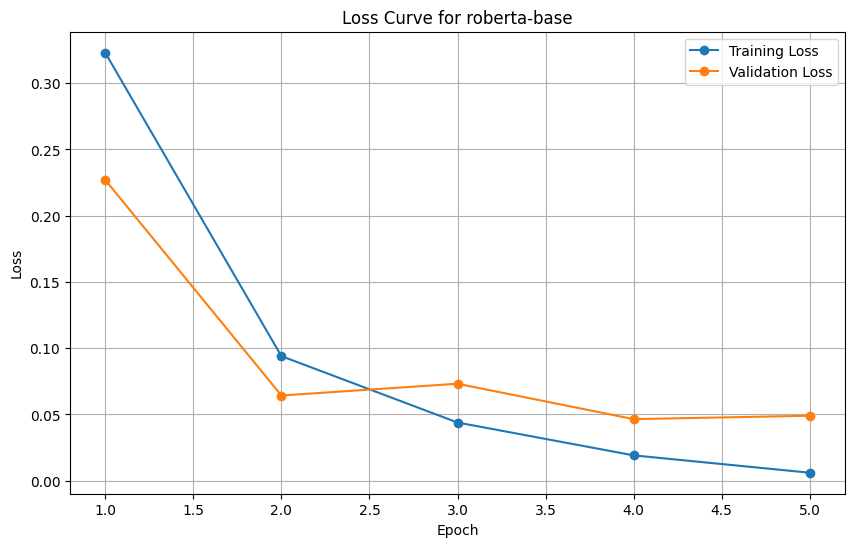

Evaluating roberta-base on Validation Set...


{'eval_loss': 0.04644402116537094, 'eval_runtime': 6.5083, 'eval_samples_per_second': 347.403, 'eval_steps_per_second': 21.818, 'epoch': 5.0}
Evaluating roberta-base on Test Set...
{'eval_loss': 1.9824293851852417, 'eval_runtime': 4.2963, 'eval_samples_per_second': 348.675, 'eval_steps_per_second': 21.879, 'epoch': 5.0}
Generating predictions for roberta-base...
Class Accuracies for roberta-base: {0: 0.6093333333333333, 1: 0.9, 2: 0.992, 3: 0.9193548387096774}


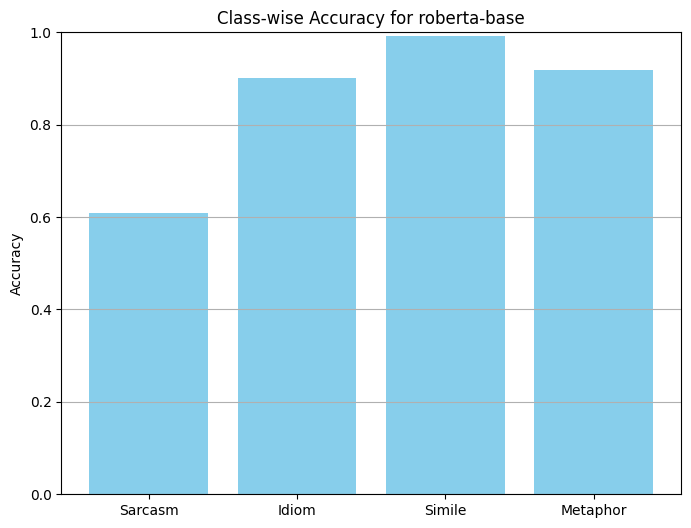

Accuracy for roberta-base: 0.77
Classification Report for roberta-base:
                    precision    recall  f1-score   support

           Sarcasm       1.00      0.61      0.76       750
             Idiom       0.94      0.90      0.92       250
            Simile       0.95      0.99      0.97       250
          Metaphor       0.92      0.92      0.92       248
CreativeParaphrase       0.00      0.00      0.00         0

          accuracy                           0.77      1498
         macro avg       0.76      0.68      0.71      1498
      weighted avg       0.97      0.77      0.85      1498



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


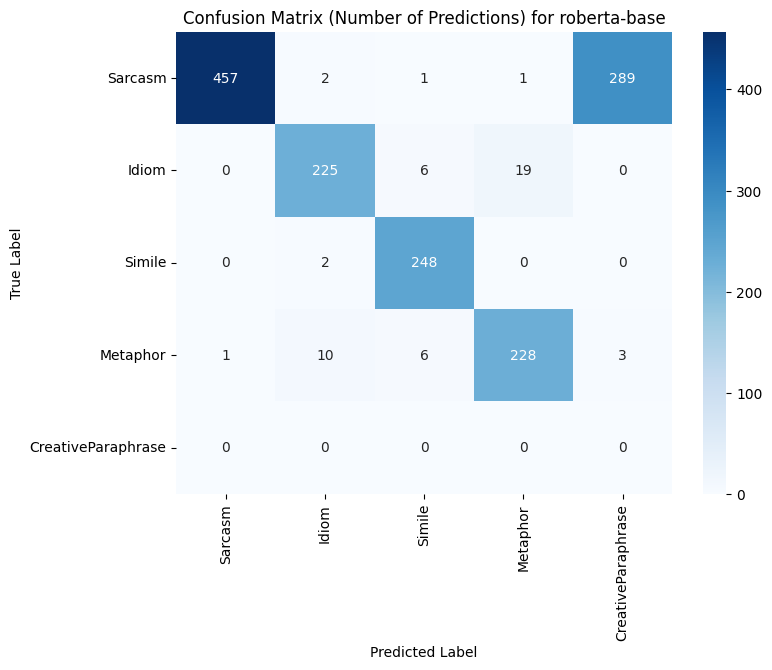

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


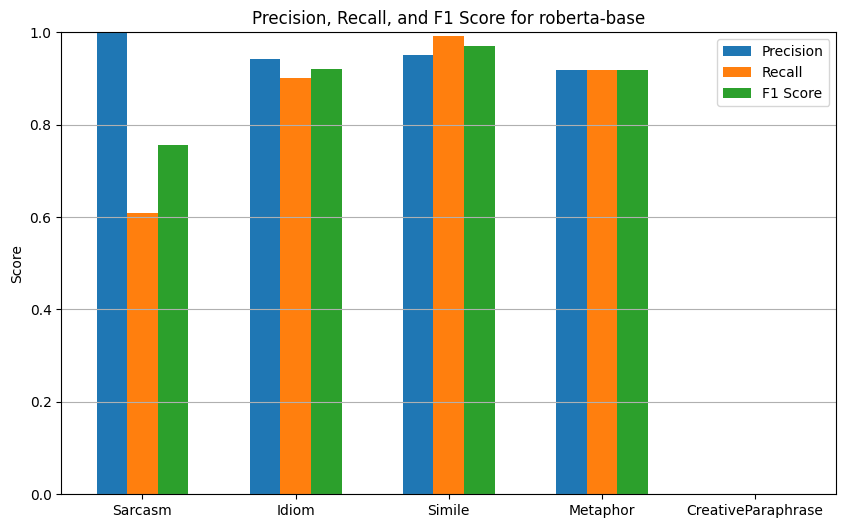

BLEU Score for roberta-base: 0.7411
Average BLEURT Score for roberta-base: 0.3851
Average BERTScore F1 for roberta-base: 0.9537


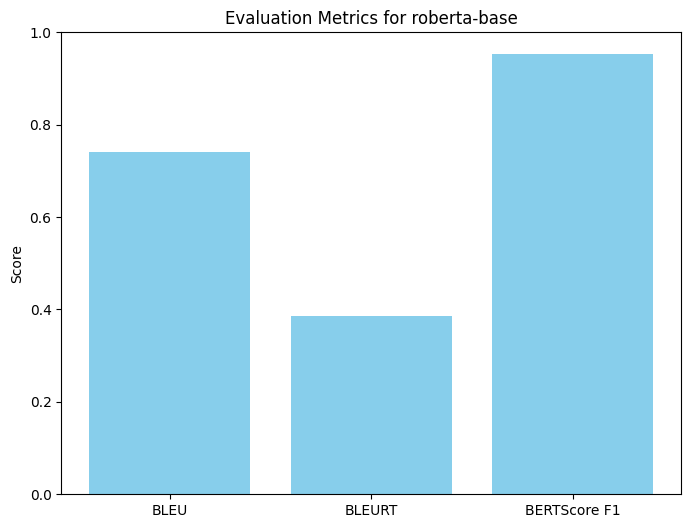

Total misclassified examples for roberta-base: 340/1498
Misclassified examples for roberta-base: [(17, 0, 4), (19, 0, 4), (21, 1, 2), (23, 0, 4), (25, 0, 4)]
Sample Misclassified Examples for roberta-base:
Example 17:
  - True Label: Sarcasm
  - Predicted Label: CreativeParaphrase
  - Premise: Mismatched prediction
  - Hypothesis: It's amazing that my boss takes advantage of me being a hard worker and never appreciates my efforts
--------------------------------------------------
Example 19:
  - True Label: Sarcasm
  - Predicted Label: CreativeParaphrase
  - Premise: Mismatched prediction
  - Hypothesis: I was really excited to inherit my mom's old car but when I got it, I realized the trunk leaked
--------------------------------------------------
Example 21:
  - True Label: Idiom
  - Predicted Label: Simile
  - Premise: Mismatched prediction
  - Hypothesis: The thought made her uneasy, once again feel like something under the microscope.
----------------------------------------------

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9043 [00:00<?, ? examples/s]

Map:   0%|          | 0/9043 [00:00<?, ? examples/s]

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Setting training arguments for bert-base-uncased...
Initializing Trainer for bert-base-uncased...
Training bert-base-uncased...


Epoch,Training Loss,Validation Loss
1,0.253500,0.067551
2,0.057900,0.052010
3,0.017900,0.040593
4,0.008300,0.035216
5,0.002400,0.026445


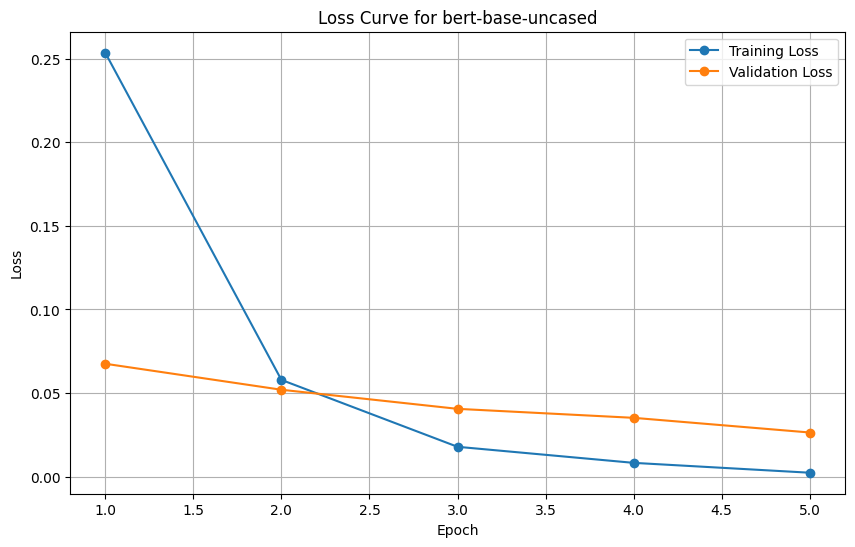

Evaluating bert-base-uncased on Validation Set...


{'eval_loss': 0.02644495852291584, 'eval_runtime': 7.3997, 'eval_samples_per_second': 305.554, 'eval_steps_per_second': 19.19, 'epoch': 5.0}
Evaluating bert-base-uncased on Test Set...
{'eval_loss': 1.8217613697052002, 'eval_runtime': 5.0007, 'eval_samples_per_second': 299.561, 'eval_steps_per_second': 18.798, 'epoch': 5.0}
Generating predictions for bert-base-uncased...
Class Accuracies for bert-base-uncased: {0: 0.616, 1: 0.944, 2: 0.992, 3: 0.907258064516129}


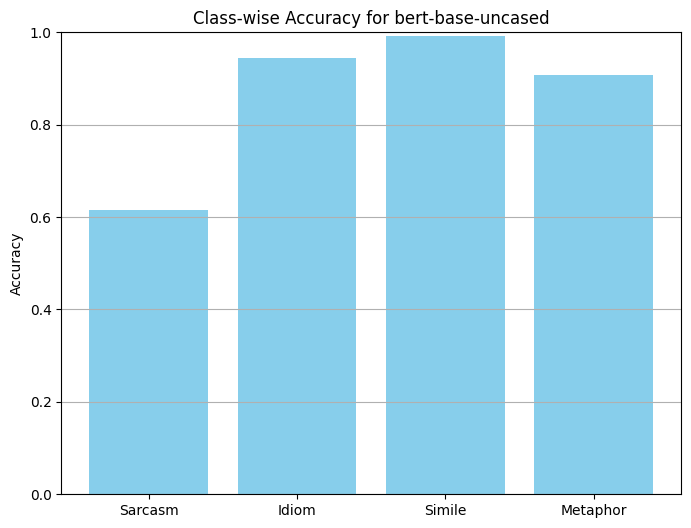

Accuracy for bert-base-uncased: 0.78
Classification Report for bert-base-uncased:
                    precision    recall  f1-score   support

           Sarcasm       1.00      0.62      0.76       750
             Idiom       0.92      0.94      0.93       250
            Simile       0.97      0.99      0.98       250
          Metaphor       0.94      0.91      0.92       248
CreativeParaphrase       0.00      0.00      0.00         0

          accuracy                           0.78      1498
         macro avg       0.77      0.69      0.72      1498
      weighted avg       0.97      0.78      0.85      1498



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


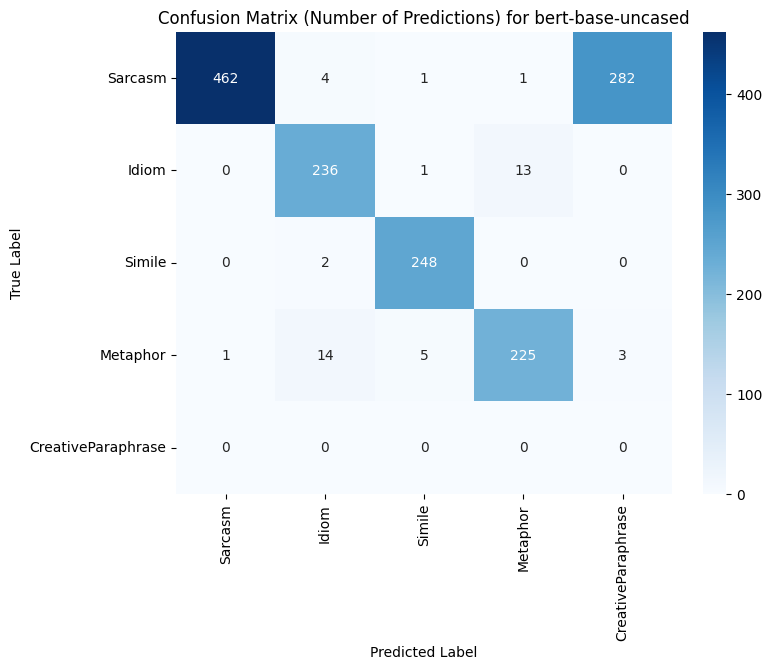

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


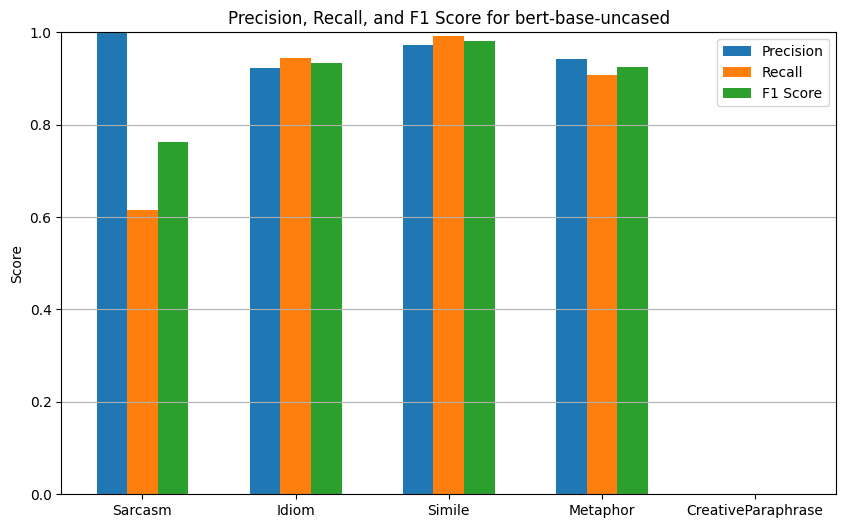

BLEU Score for bert-base-uncased: 0.7528
Average BLEURT Score for bert-base-uncased: 0.4061
Average BERTScore F1 for bert-base-uncased: 0.9555


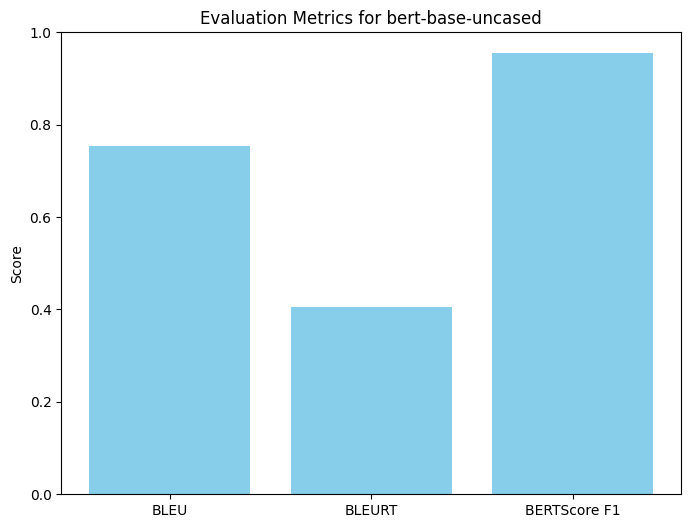

Total misclassified examples for bert-base-uncased: 327/1498
Misclassified examples for bert-base-uncased: [(17, 0, 4), (19, 0, 4), (23, 0, 4), (25, 0, 4), (35, 0, 1)]
Sample Misclassified Examples for bert-base-uncased:
Example 17:
  - True Label: Sarcasm
  - Predicted Label: CreativeParaphrase
  - Premise: Mismatched prediction
  - Hypothesis: It's amazing that my boss takes advantage of me being a hard worker and never appreciates my efforts
--------------------------------------------------
Example 19:
  - True Label: Sarcasm
  - Predicted Label: CreativeParaphrase
  - Premise: Mismatched prediction
  - Hypothesis: I was really excited to inherit my mom's old car but when I got it, I realized the trunk leaked
--------------------------------------------------
Example 23:
  - True Label: Sarcasm
  - Predicted Label: CreativeParaphrase
  - Premise: Mismatched prediction
  - Hypothesis: The fact that the price for the part I need for my computer went up 10% right before I decided to b

,Model,Accuracy,BLEU,BLEURT,BERTScore F1
0,roberta-base,0.773031,0.741106,0.385128,0.953750
1,bert-base-uncased,0.781709,0.752791,0.406073,0.955464


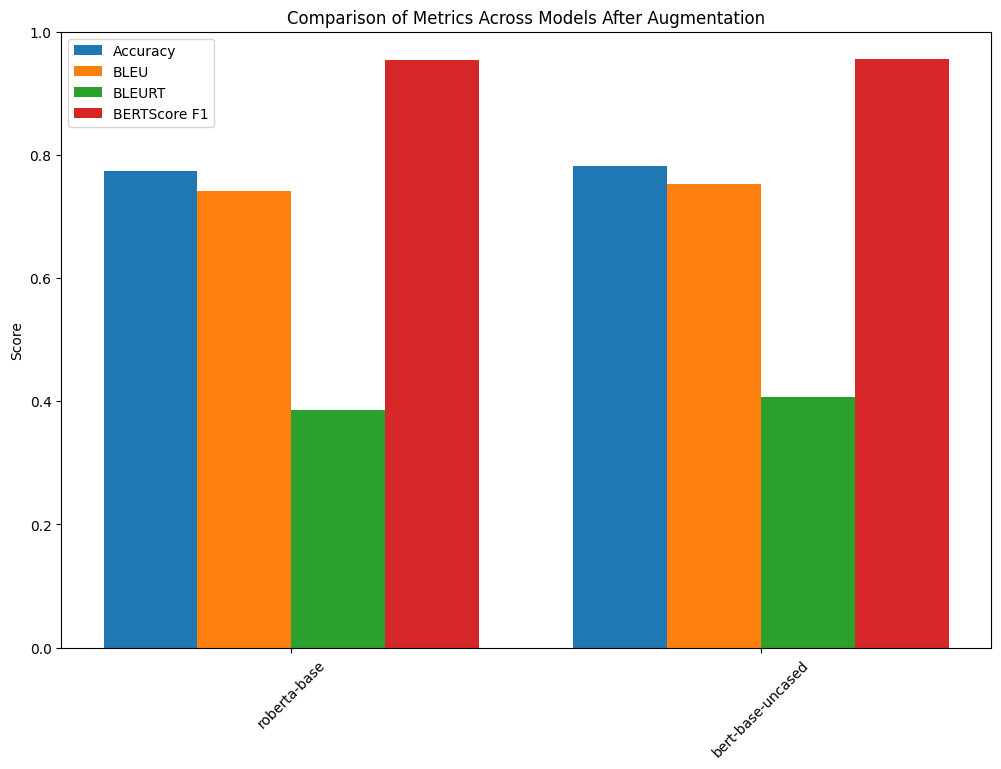

In [ ]:
#Converting augmented Pandas DataFrames to Hugging Face Datasets
hf_aug_flute_train=Dataset.from_pandas(augmented_flute_train)
hf_aug_flute_val=Dataset.from_pandas(augmented_flute_val)

#List of the models
model_names=[
    "roberta-base",
    "bert-base-uncased"
]

#Initializing a list to store performance metrics for all models
model_performance=[]

#Loop through each model
for model_name in model_names:
    print(f"\n{'='*50}\nProcessing Model: {model_name}\n{'='*50}\n")

    #Setting seed inside the loop for reproducibility in each iteration
    set_seed(101)

    #Loading Tokenizer and Model
    tokenizer=AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model=AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
    model.gradient_checkpointing_enable()

    #Re-Tokenizing the augmented FLUTE Training and Validation Sets and also Re-Tokenizing the FLUTE test set
    tokenized_aug_flute_train=hf_aug_flute_train.map(tokenize_function, batched=True)
    tokenized_aug_flute_train=tokenized_aug_flute_train.map(lambda x: {"labels": type_mapping[x["type"]]})
    tokenized_aug_flute_train=tokenized_aug_flute_train.remove_columns(["label", "type", "id", "premise", "hypothesis", "explanation", "split", "idiom", "__index_level_0__"])

    tokenized_aug_flute_val=hf_aug_flute_val.map(tokenize_function, batched=True)
    tokenized_aug_flute_val=tokenized_aug_flute_val.map(lambda x: {"labels": type_mapping[x["type"]]})
    tokenized_aug_flute_val=tokenized_aug_flute_val.remove_columns(["label", "type", "id", "premise", "hypothesis", "explanation", "split", "idiom", "__index_level_0__"])

    tokenized_flute_test_2=hf_test_dataset.map(tokenize_function, batched=True)
    tokenized_flute_test_2=tokenized_flute_test_2.map(lambda x: {"labels": type_mapping[x["type"]]})
    tokenized_flute_test_2=tokenized_flute_test_2.remove_columns(["label", "type", "id", "premise", "hypothesis", "explanation", "split", "idiom"])

    #Inspecting the Tokenizer Output After Augmentation
    print(tokenizer("premise", "augmented hypothesis").keys())

    #Defining Training Arguments
    print(f"Setting training arguments for {model_name}...")
    training_args=TrainingArguments(
        output_dir=f"./results/{model_name}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        save_total_limit=2,
        logging_dir=f"./logs/{model_name}",
        load_best_model_at_end=True,
        fp16=False,
        seed=101,
    )

    #Defining Trainer
    print(f"Initializing Trainer for {model_name}...")
    trainer=Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_aug_flute_train,
        eval_dataset=tokenized_aug_flute_val,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    #Training the Model
    print(f"Training {model_name}...")
    trainer.train()

    #Extracting epoch-wise training and evaluation loss
    training_logs=trainer.state.log_history  #Access log history
    training_loss=[log["loss"] for log in training_logs if "loss" in log and "epoch" in log]
    eval_loss=[log["eval_loss"] for log in training_logs if "eval_loss" in log]

    #Checking if logs are available
    if len(training_loss)==0 or len(eval_loss)==0:
      print(f"Warning: No sufficient training or validation loss data for {model_name}. Skipping loss plot.")
    else:
      #Ensuring lengths match
      min_len=min(len(training_loss), len(eval_loss))
      training_loss=training_loss[:min_len]
      eval_loss=eval_loss[:min_len]
      epochs=range(1, len(eval_loss)+1)

    #Plot the training and evaluation loss
    plt.figure(figsize=(10,6))
    plt.plot(epochs, training_loss[:len(eval_loss)], label="Training Loss", marker="o")  #Adjusting length to match
    plt.plot(epochs, eval_loss, label="Validation Loss", marker="o")
    plt.title(f"Loss Curve for {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    #Evaluating on Validation Set
    print(f"Evaluating {model_name} on Validation Set...")
    val_results=trainer.evaluate(tokenized_aug_flute_val)
    print(val_results)

    #Evaluating on Test Set
    print(f"Evaluating {model_name} on Test Set...")
    test_results=trainer.evaluate(tokenized_flute_test_2)
    print(test_results)

    #Generating Predictions and Metrics
    print(f"Generating predictions for {model_name}...")
    predictions=trainer.predict(tokenized_flute_test_2)
    predicted_labels=predictions.predictions.argmax(axis=1)
    true_labels=predictions.label_ids

    #Mapping label indices to class names
    label_to_name_mapping={0:"Sarcasm", 1:"Idiom", 2:"Simile", 3:"Metaphor", 4:"CreativeParaphrase"}

    #Converting predicted labels to corresponding hypothesis texts and defining references for BLEU, BLEURT, and BERTScore
    predictions_text=[test_df.iloc[i]["hypothesis"] if predicted_labels[i]==true_labels[i] else "Mismatched prediction"
                      for i in range(len(predicted_labels))]
    references=list(test_df["hypothesis"])

    #Getting unique classes in the test set
    unique_classes_in_test=sorted(list(set(true_labels)))

    #Getting class names dynamically from the available labels
    filtered_class_names=[label_to_name_mapping[label] for label in unique_classes_in_test]

    #Per-Class Accuracy (only for classes present in the test set)
    accuracy_per_class={
        label:((np.array(true_labels)==label)&(np.array(predicted_labels)==label)).sum()
        /(np.array(true_labels)==label).sum() if (np.array(true_labels)==label).sum()>0 else 0.0
        for label in unique_classes_in_test}

    print(f"Class Accuracies for {model_name}:", accuracy_per_class)

    #Visualizing Bar plot for Class Accuracy
    plt.figure(figsize=(8,6))
    plt.bar(
        filtered_class_names,
        [accuracy_per_class[label] for label in unique_classes_in_test],
        color="skyblue")
    plt.title(f"Class-wise Accuracy for {model_name}")
    plt.ylabel("Accuracy")
    plt.ylim(0,1)
    plt.grid(axis="y")
    plt.show()

    #Overall Accuracy
    accuracy=accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy for {model_name}: {accuracy:.2f}")

    #Classification Report
    report=classification_report(
        true_labels, predicted_labels, target_names=["Sarcasm", "Idiom", "Simile", "Metaphor", "CreativeParaphrase"]
    )
    print(f"Classification Report for {model_name}:\n{report}")

    #Confusion Matrix
    cm=confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2, 3, 4])
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Sarcasm", "Idiom", "Simile", "Metaphor", "CreativeParaphrase"],
                yticklabels=["Sarcasm", "Idiom", "Simile", "Metaphor", "CreativeParaphrase"])
    plt.title(f"Confusion Matrix (Number of Predictions) for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    #Precision, Recall, and F1-Score Bar Chart
    precision, recall, f1, _=precision_recall_fscore_support(true_labels, predicted_labels, labels=[0, 1, 2, 3, 4])
    x=np.arange(len(precision))
    width=0.2

    plt.figure(figsize=(10,6))
    plt.bar(x-width, precision, width, label="Precision")
    plt.bar(x, recall, width, label="Recall")
    plt.bar(x+width, f1, width, label="F1 Score")
    plt.xticks(x, ["Sarcasm", "Idiom", "Simile", "Metaphor", "CreativeParaphrase"])
    plt.title(f"Precision, Recall, and F1 Score for {model_name}")
    plt.ylabel("Score")
    plt.ylim(0,1)
    plt.legend()
    plt.grid(axis="y")
    plt.show()

    #BLEU Score
    bleu_result=bleu_metric.compute(predictions=predictions_text, references=[[ref] for ref in references])
    print(f"BLEU Score for {model_name}: {bleu_result['bleu']:.4f}")
    bleu_score=bleu_result["bleu"]

    #BLEURT Score
    bleurt_result=bleurt_metric.compute(predictions=predictions_text, references=references)
    avg_bleurt=np.mean(bleurt_result["scores"])
    print(f"Average BLEURT Score for {model_name}: {avg_bleurt:.4f}")

    #BERTScore
    bertscore_result=bertscore_metric.compute(predictions=predictions_text, references=references, lang="en")
    avg_bertscore_f1=np.mean(bertscore_result["f1"])
    print(f"Average BERTScore F1 for {model_name}: {avg_bertscore_f1:.4f}")

    #Saving the performance data for the models
    model_performance.append({
        "Model": model_name, "Accuracy": accuracy, "BLEU": bleu_score, "BLEURT": avg_bleurt, "BERTScore F1": avg_bertscore_f1})

    #Bar plot for BLEU, BLEURT, BERTScore
    plt.figure(figsize=(8,6))
    metrics=["BLEU", "BLEURT", "BERTScore F1"]
    values=[bleu_result["bleu"], avg_bleurt, avg_bertscore_f1]
    plt.bar(metrics, values, color="skyblue")
    plt.title(f"Evaluation Metrics for {model_name}")
    plt.ylabel("Score")
    plt.ylim(0,1)
    plt.show()

    #Misclassified Examples
    misclassified=[(i, true, pred) for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)) if true!=pred]
    print(f"Total misclassified examples for {model_name}: {len(misclassified)}/{len(true_labels)}")
    print(f"Misclassified examples for {model_name}:", misclassified[:5])

    #Textual Analysis of Misclassified Examples
    misclassified=[(i, references[i], predictions_text[i], true, pred) for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)) if true!=pred]
    print(f"Sample Misclassified Examples for {model_name}:")
    for idx, ref, pred_text, true, pred in misclassified[:5]:
        print(f"Example {idx}:")
        print(f"  - True Label: {label_to_name_mapping[true]}")
        print(f"  - Predicted Label: {label_to_name_mapping[pred]}")
        print(f"  - Premise: {pred_text}")
        print(f"  - Hypothesis: {ref}")
        print("-"*50)

#Creating a DataFrame for performance visualization
performance_df=pd.DataFrame(model_performance)

#Displaying performance comparison table
print("Model Performance Comparison Table After Augmentation:")
display(performance_df)

#Comparison bar chart for all metrics across models
metrics=["Accuracy", "BLEU", "BLEURT", "BERTScore F1"]
plt.figure(figsize=(12,8))

#Plotting each metric for all models
for i, metric in enumerate(metrics):
    plt.bar(
        [x+i*0.2 for x in range(len(model_names))],
        performance_df[metric],
        width=0.2,
        label=metric
    )

#Configuring the plot
plt.xticks([x+0.3 for x in range(len(model_names))], performance_df["Model"], rotation=45)
plt.ylabel("Score")
plt.title("Comparison of Metrics Across Models After Augmentation")
plt.ylim(0, 1)
plt.legend()
plt.show()